
    
## Overview

This managed-instance notebook provides a tutorial on building, deploying and analyzing predictions from a simple [Random-Forest](https://en.wikipedia.org/wiki/Random_forest) model using tools like like Sklearn, Vertex-AI and What-IF Tool ([WIT](https://cloud.google.com/ai-platform/prediction/docs/using-what-if-tool)) on a Synthetic Fraud Transcation dataset to solve a financial fraud detection problem. 


## Dataset

The dataset used in this tutorial is publicly availabe as the following Kaggle dataset. Further details about the dataset can be found at the corresponding page. 
- [Synthetic Financial Datasets For Fraud Detection](https://www.kaggle.com/ealaxi/paysim1)


## Objective

This tutorial demonstrates data-analysis and model building on a synthetic financial dataset. The model will be trained on identifying fraudulent cases among the transactions. Further, the trained model is deployed on Vertex-AI Endpoints and analyzed using What-If Tool. In detail, the steps taken in this tutorial are as follows : 

- Installation of required libraries
- Reading the dataset from Cloud-storage bucket
- Performing Exploratory Analysis on the dataset
- Preprocessing the dataset
- Training a Random-Forest model using sklearn
- Saving the model to a Cloud-storage bucket
- Creating a Vertex-AI model resource

## Costs

This tutorial uses billable components of Google Cloud:

* Vertex AI
* Cloud Storage

Learn about [Vertex AI
pricing](https://cloud.google.com/vertex-ai/pricing) and [Cloud Storage
pricing](https://cloud.google.com/storage/pricing), and use the [Pricing
Calculator](https://cloud.google.com/products/calculator/)
to generate a cost estimate based on your projected usage. 

## Kernel Configuration

Select the Tensorflow kernel while running this notebook on Vertex-AI's managed instances. Tensorflow kernel comes with the What-IF tool installed and configured by default.

## Installation

In [140]:
import os

# The Google Cloud Notebook product has specific requirements
IS_GOOGLE_CLOUD_NOTEBOOK = os.path.exists("/opt/deeplearning/metadata/env_version")

USER_FLAG = ""
# Google Cloud Notebook requires dependencies to be installed with '--user'
if IS_GOOGLE_CLOUD_NOTEBOOK:
    USER_FLAG = "--user"

Install the latest version of the Vertex AI client library.

Run the following command in your virtual environment to install the Vertex SDK for Python:

In [ ]:
! pip install {USER_FLAG} --upgrade google-cloud-aiplatform

### Providing the Cloud Storage bucket name

**The following steps are required, regardless of your notebook environment.**


When you create a model in Vertex-AI using the Cloud SDK, you give a Cloud Storage path where the trained model is saved. 
In this tutorial, Vertex AI saves the trained model to a GCS bucket. Using this model artifact, you can then
create Vertex AI model and endpoint resources in order to serve
online predictions.

Following code sets the name of your Cloud Storage bucket according to bucket created by "Deploy Demo". Bucket name will be unique across all
Cloud Storage buckets.

You may also change the `REGION` variable, which is used for operations
throughout the rest of this notebook. Make sure to [choose a region where Vertex AI services are
available](https://cloud.google.com/vertex-ai/docs/general/locations#available_regions). You may
not use a Multi-Regional Storage bucket for training with Vertex AI.

In [29]:
Project_ID = !(gcloud config get-value core/project)
Project_ID = Project_ID[0]
BUCKET_NAME = Project_ID  # @param {type:"string"}
REGION = "us-central1"  # @param {type:"string"}

Finally, validate access to your Cloud Storage bucket by examining its contents:

In [4]:
! gsutil ls -al gs://$BUCKET_NAME

     80694  2022-08-16T19:35:26Z  gs://bryanfreeman-267-2022081619260/Automated_Fraud_Transaction_Detection_notebook.ipynb#1660678526478497  metageneration=1
 493534783  2022-08-16T19:35:32Z  gs://bryanfreeman-267-2022081619260/PS_20174392719_1491204439457_log.csv#1660678532576659  metageneration=1
       230  2022-08-16T19:35:26Z  gs://bryanfreeman-267-2022081619260/post_script.sh#1660678526438986  metageneration=1
TOTAL: 3 objects, 493615707 bytes (470.75 MiB)


### Loaded dataset into your Cloud Storage bucket by "Deploy Demo"

<b>PS_20174392719_1491204439457_log.csv</b> file of "[Synthetic Financial Datasets for Fraud detection](https://www.kaggle.com/ealaxi/paysim1)" from Kaggle competition page is loaded to the created bucket.

## Tutorial

### Import required libraries

In [62]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score, f1_score, confusion_matrix, accuracy_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
import pickle 
from google.cloud import storage
from google.cloud import aiplatform as vertex_ai
from datetime import datetime

import warnings
warnings.filterwarnings("ignore")

In [6]:
# Load dataset
if BUCKET_NAME == "":
   FILE_PATH = "[local-file-path]"
else :
   FILE_PATH = "gs://"+BUCKET_NAME +"/PS_20174392719_1491204439457_log.csv"
df = pd.read_csv(FILE_PATH)

## Analyze the dataset

Take a quick look at the dataset and the number of rows.

In [7]:
print ("shape : ",df.shape)
df.head()

shape :  (6362620, 11)


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


Check for null values

In [8]:
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

Check the type of transactions involved

CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: type, dtype: int64


Text(0, 0.5, 'Amount')

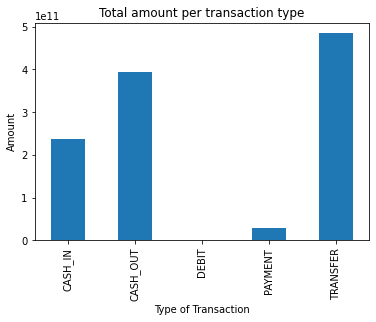

In [9]:
print(df.type.value_counts())
var = df.groupby('type').amount.sum()
fig = plt.figure()
ax1 = fig.add_subplot(1,1,1)
var.plot(kind='bar')
ax1.set_title("Total amount per transaction type")
ax1.set_xlabel('Type of Transaction')
ax1.set_ylabel('Amount')

## Working with imbalanced data

Althuogh the outcome variable "isFraud" seems to be very imbalanced in the current dataset, a base model can be trained on it to check the quality of fraudulent transactions in the data and further if needed, counter measures like undersampling of majority class or oversampling of the minority class can be considered.

In [10]:
# Count number of fraudulent/non-fraudulent transactions
df.isFraud.value_counts() 

0    6354407
1       8213
Name: isFraud, dtype: int64

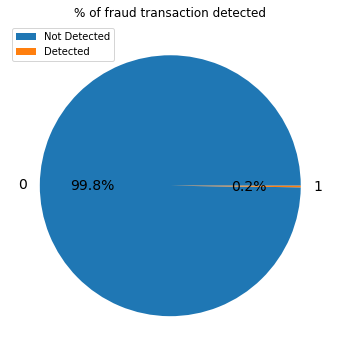

In [11]:
piedata = df.groupby(['isFlaggedFraud']).sum()
f, axes = plt.subplots(1,1, figsize=(6,6))
axes.set_title("% of fraud transaction detected")
piedata.plot(kind='pie',y='isFraud',ax=axes, fontsize=14,shadow=False,autopct='%1.1f%%');
axes.set_ylabel('');
plt.legend(loc='upper left',labels=['Not Detected','Detected'])
plt.show()

## Prepare data for modeling
To prepare the dataset for training a few columns need to be dropped that contain either unique data ('nameOrig','nameDest') or redundant fields ('isFlaggedFraud'). The categorical field "type" which describes the type of transaction and is important for fraud detection needs to be one-hot encoded.


In [12]:
df.drop(['nameOrig','nameDest','isFlaggedFraud'],axis=1,inplace=True)

In [13]:
X = pd.concat([df.drop('type', axis=1), pd.get_dummies(df['type'])], axis=1)
X.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER
0,1,9839.64,170136.0,160296.36,0.0,0.0,0,0,0,0,1,0
1,1,1864.28,21249.0,19384.72,0.0,0.0,0,0,0,0,1,0
2,1,181.00,181.0,0.00,0.0,0.0,1,0,0,0,0,1
3,1,181.00,181.0,0.00,21182.0,0.0,1,0,1,0,0,0
4,1,11668.14,41554.0,29885.86,0.0,0.0,0,0,0,0,1,0


Remove the outcome variable from the training data

In [14]:
y = X[['isFraud']]
X = X.drop(['isFraud'],axis=1)

Split the data and assign 70% for training and 30% for testing

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3,random_state=42, shuffle=False)
print (X_train.shape, X_test.shape)

(4453834, 11) (1908786, 11)


## Fit a Random-forest model

Fit a simple Random-Forest classifier on the preprocessed train dataset.

### Set Experiment Configurations

In [32]:
VERSION = 'v01'
DATASET_DISPLAY_NAME = 'synthetic-financial-fraud'
MODEL_DISPLAY_NAME = f'{DATASET_DISPLAY_NAME}-classifier-{VERSION}'

WORKSPACE = f'gs://{BUCKET_NAME}/{DATASET_DISPLAY_NAME}'
EXPERIMENT_ARTIFACTS_DIR = os.path.join(WORKSPACE, 'experiments')
EXPERIMENT_NAME = DATASET_DISPLAY_NAME

### Initialize Experiment

In [50]:
vertex_ai.init(
    project=Project_ID,
    location=REGION,
    staging_bucket=BUCKET_NAME,
    experiment=EXPERIMENT_NAME
)
EXPERIMENT_RUN_DIR = os.path.join(EXPERIMENT_ARTIFACTS_DIR, EXPERIMENT_NAME, run_id)
print("Experiment run directory:", EXPERIMENT_RUN_DIR)

Experiment run directory: gs://bryanfreeman-267-2022081619260/synthetic-financial-fraud/experiments/synthetic-financial-fraud/run-local-20220823133411


### Set Hyperparameters

In [57]:
N_ESTIMATORS = 110

### Start Experiment Run

In [58]:
run_id = f"run-local-{datetime.now().strftime('%Y%m%d%H%M%S')}"
run = vertex_ai.start_run(run_id)
data_params = {"n_estimators": N_ESTIMATORS}
run.log_params(data_params)
forest=RandomForestClassifier(n_estimators=N_ESTIMATORS)
forest.fit(X_train,y_train)

Associating projects/1058998137713/locations/us-central1/metadataStores/default/contexts/synthetic-financial-fraud-run-local-20220823141655 to Experiment: synthetic-financial-fraud


RandomForestClassifier(n_estimators=110)

## Analyzing Results

The model returns good scores but the confusion matrix really brings the point home that this model can indeed work with imbalanced data.

In [59]:
y_prob=forest.predict_proba(X_test)
y_pred=forest.predict(X_test)

precision_score = average_precision_score(y_test, y_prob[:, 1])
print('AUPRC :', precision_score)

f1 = f1_score(y_test,y_pred)
print('F1 - score :',f1)

cm = confusion_matrix(y_test,y_pred)
print('Confusion_matrix : ')
print(cm)

cr = classification_report(y_test,y_pred)
print("classification_report")
print(cr)

run.log_metrics({"average_precision_score": precision_score, 
                 "f1_score": f1})
run.end_run()

AUPRC : 0.9268633911846218
F1 - score : 0.8514999999999999
Confusion_matrix : 
[[1904192      24]
 [   1164    3406]]
classification_report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1904216
           1       0.99      0.75      0.85      4570

    accuracy                           1.00   1908786
   macro avg       1.00      0.87      0.93   1908786
weighted avg       1.00      1.00      1.00   1908786



Use RandomForestClassifier feature_importances_ function to get an better understanding about which features were the most useful to the model.

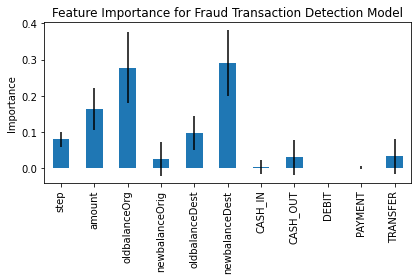

In [61]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
forest_importances = pd.Series(importances, index=list(X_train))
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature Importance for Fraud Transaction Detection Model")
ax.set_ylabel("Importance")
fig.tight_layout()

## Save the model artifact

In [117]:
FILE_NAME = 'model.pkl'
LOCAL_PATH = 'model'

#Save model to local file system, does not persist
with open(local_path, 'wb') as model_file:
  pickle.dump(forest, model_file)

# Upload model artifact to Cloud Storage
AIP_BUCKET = 'cloud-ai-platform-8c917cf7-47f7-4746-a08e-dd04ba7091af'
BLOB_PATH = AIP_BUCKET+"/models/"
ARTIFACT_GCS_PATH = f'gs://{BLOB_PATH}'
print(ARTIFACT_GCS_PATH)

#model_directory = os.environ['ARTIFACT_GCS_PATH']
storage_path = os.path.join(ARTIFACT_GCS_PATH, FILE_NAME)
blob = storage.blob.Blob.from_string(storage_path, client=storage.Client())
blob.upload_from_filename(local_path)

gs://cloud-ai-platform-8c917cf7-47f7-4746-a08e-dd04ba7091af/models/


## Add Model to Registry

In [139]:
!gcloud ai models upload \
  --region=us-central1 \
  --display-name=financial-fraud-synthetic \
  --container-image-uri=us-docker.pkg.dev/vertex-ai/prediction/sklearn-cpu.0-20:latest\
  --artifact-uri=gs://cloud-ai-platform-8c917cf7-47f7-4746-a08e-dd04ba7091af/models/

Using endpoint [https://us-central1-aiplatform.googleapis.com/]
Waiting for operation [4076958673065213952]...done.                            
